# Introduction


The goal of this project is to uncover key insights through a statistical analysis of Katingos sales data from the first nine months of the year. Additionally, the client aims to determine, with statistical evidence, which e-commerce platform generates the highest sales for their baby product line. The insights derived from this analysis will support the marketing team in optimizing their advertising strategies and improving overall campaign performance.

# Coding

## Loading libraries


Let's import all the libraries that we are going to use first.

In [47]:
import pandas as pd
import numpy as np
import math as mt
from scipy import stats as st
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick


## Loading data

Now we load the data from a CSV file with all the sales from january to september 2025.

In [7]:
sales = pd.read_csv('jan_sep_2025_sales.csv', encoding='latin-1')


## Exploratory Data Analysis (EDA)


First let's take a quick look of the information.

In [10]:

print(sales.info())
print(sales.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384 entries, 0 to 1383
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    1384 non-null   int64  
 1   Week                     1384 non-null   int64  
 2   Channel                  1384 non-null   object 
 3   State                    1366 non-null   object 
 4   Baby Peanut 250g         700 non-null    float64
 5   Crunchy Peanut 250g      118 non-null    float64
 6   Baby Almond 250g         646 non-null    float64
 7   Vainilla Almond 250g     109 non-null    float64
 8   Chocolate Hazelnut 250g  102 non-null    float64
 9   Baby  Peanut 1kg         170 non-null    float64
 10  Baby Almond 1kg          11 non-null     float64
 11  Crunchy Peanut 1kg       155 non-null    float64
 12  Vainilla Almond 1kg      11 non-null     float64
 13  Chocolate Hazelnut 1kg   12 non-null     float64
 14  Non Crunchy Peanut 4kg  


Looking at the dataset, we can confirm this one is a table with sales and each line it's a different ticket for an specific customer. That is why we have NaN values, because every customer buys some specific products. There are some things we can do to improve our dataset:  
  
1. For style purpose we'll unify the columns names, changing them to lowercase, and replacing spaces with underscores.  
2. To simplify the data wrangling, we can sustitute the NaN values for ceros, this means that the customer didn't buy that product.  
3. Also for data wrangling and because the customers do not buy half's of products, we can change the products columns info into integer type.

In [ ]:
# First we change the columns names from uppercases to lowercases.
new_col_name = []

for old_name in sales.columns:
    low_name = old_name.lower()
    stripped_name = '_'.join(old_name.split())
    new_col_name.append(stripped_name)

sales.columns = new_col_name

# Now let's impute zeros in the products columns.
exclude_col = ['month', 'week', 'channel', 'state']
col_to_fill = sales.columns.difference(exclude_col)
sales[col_to_fill] = sales[col_to_fill].fillna(0)

# Finally we change the products columns type to integer.
sales[col_to_fill] = sales[col_to_fill].astype('int')
print(sales.head())

   month  week channel      state  baby_peanut_250g  crunchy_peanut_250g  \
0      1     1      AZ    Jalisco                 1                    0   
1      1     1      AZ  Querétaro                 1                    0   
2      1     1      AZ       León                 1                    0   
3      1     1      AZ    Jalisco                 0                    0   
4      1     1      AZ       CDMX                 1                    0   

   baby_almond_250g  vainilla_almond_250g  chocolate_hazelnut_250g  \
0                 1                     0                        0   
1                 1                     0                        0   
2                 1                     0                        0   
3                 0                     0                        0   
4                 1                     0                        0   

   baby_peanut_1kg  baby_almond_1kg  crunchy_peanut_1kg  vainilla_almond_1kg  \
0                0                0       


## Data Wrangling


For the purpose of the project, we need to translate the amount of products selled into money. And for simplifying the analysis it's a good idea to calculate the total sales for each one of the product lines that we want to do A/B tests. We'll set 3 different product lines and calculate the amount of money for each of them. Finally we'll calculate the total sale for each ticket.

In [23]:

# Let's calculate the money sales for the baby product line.
sales['baby_sales'] = (sales['baby_peanut_250g']*100)+(sales['baby_almond_250g']*200)+(sales['baby_peanut_1kg']*280)+(sales['baby_almond_1kg']*600)

# Now we do the same for the business product line.
sales['business_sales'] = (sales['non_crunchy_peanut_4kg']*500)+(sales['crunchy_peanut_4kg']*500)+(sales['vainilla_almond_4kg']*2000)+(sales['chocolate_hazelnut_4kg']*2000)

# The rest of the products are considered as the wellness product line.
sales['wellness_sales'] = (sales['crunchy_peanut_250g']*100)+(sales['vainilla_almond_250g']*200)+(sales['chocolate_hazelnut_250g']*200)+(sales['crunchy_peanut_1kg']*280)+(sales['vainilla_almond_1kg']*600)+(sales['chocolate_hazelnut_1kg']*600)

# Finally we calculate the total amount for every ticket.
sales['total_sales'] = sales['baby_sales']+sales['business_sales']+sales['wellness_sales']
print(sales.head(10))

   month  week      channel      state  baby_peanut_250g  crunchy_peanut_250g  \
0      1     1           AZ    Jalisco                 1                    0   
1      1     1           AZ  Querétaro                 1                    0   
2      1     1           AZ       León                 1                    0   
3      1     1           AZ    Jalisco                 0                    0   
4      1     1           AZ       CDMX                 1                    0   
5      1     1           AZ     Sonora                 1                    0   
6      1     1           AZ       León                 1                    0   
7      1     1           AZ       CDMX                 0                    0   
8      1     1           AZ       CDMX                 0                    0   
9      1     1  Ptos. Venta       León                 0                    0   

   baby_almond_250g  vainilla_almond_250g  chocolate_hazelnut_250g  \
0                 1                   


## Statistical Analysis


We aim to uncover key insights for Katingos Marketing Department by analyzing various aspects of sales performance, such as sales by state, sales by channel, and sales by product line.

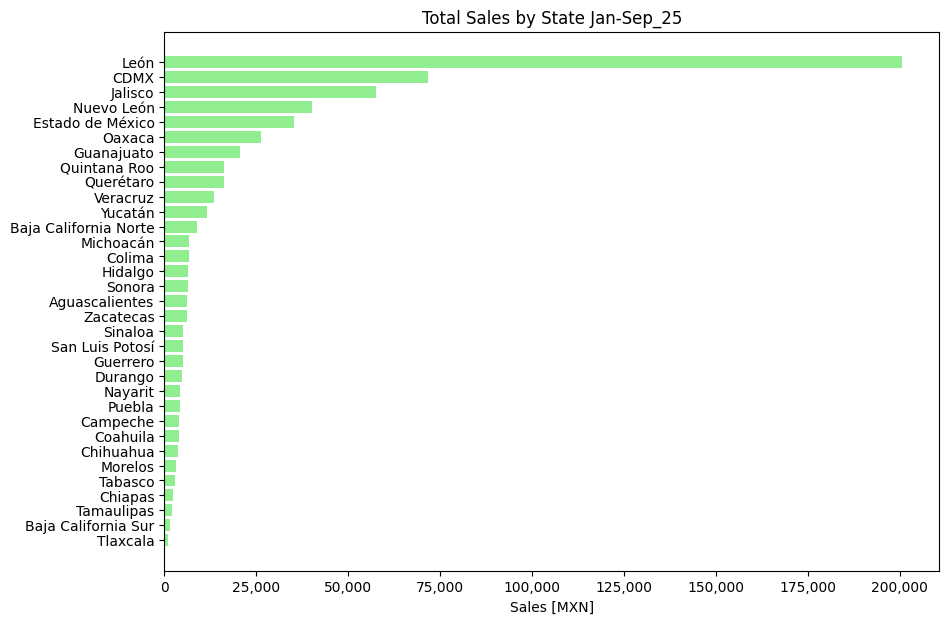

In [48]:

# Let's find out the sales by state.
state_total_sales = (sales
                    .groupby('state', as_index=False)
                    .agg(total_sales_state = ('total_sales', 'sum'))
                    )

# We order the new dataset in ascending order.
state_total_sales = state_total_sales.sort_values(by='total_sales_state', ascending=True)

# Finally we present the total sales by state in a bar graph.
plt.figure(figsize=(10,7))
plt.barh(state_total_sales['state'],state_total_sales['total_sales_state'], color='lightgreen')
plt.title('Total Sales by State Jan-Sep_25')
plt.xlabel('Sales [MXN]')
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()

         channel  total_sales_channel
2            web                 8480
4   social media               104040
1  mercado libre               115620
3         retail               152080
0         amazon               237280


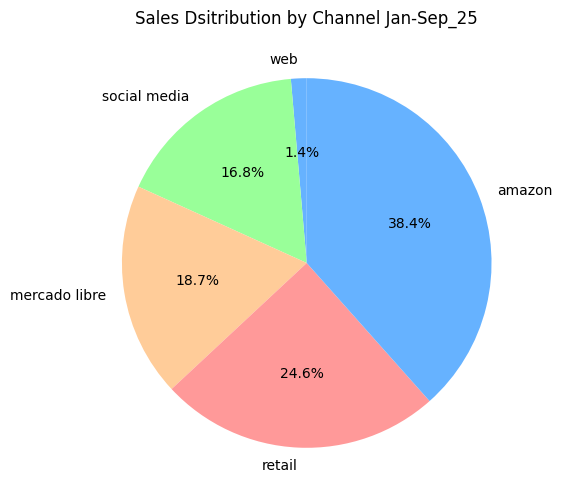

In [53]:

# Let's find out the sales by chanel.
channel_total_sales = (sales
                    .groupby('channel', as_index=False)
                    .agg(total_sales_channel=('total_sales', 'sum'))
                    )

# We order the new dataset in ascending order.
channel_total_sales = channel_total_sales.sort_values(by='total_sales_channel', ascending=True)

# The sales department asked us to change some channels names.
channel_total_sales.loc[2, 'channel'] = 'web'
channel_total_sales.loc[4, 'channel'] = 'social media'
channel_total_sales.loc[1, 'channel'] = 'mercado libre'
channel_total_sales.loc[3, 'channel'] = 'retail'
channel_total_sales.loc[0, 'channel'] = 'amazon'
print(channel_total_sales)

# Finally we present the sales distribution by channel in a pie chart.
plt.figure(figsize=(6,6))
plt.pie(channel_total_sales['total_sales_channel'], 
        labels=channel_total_sales['channel'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66B2FF', '#99FF99', '#FFCC99', '#FF9999'])
plt.title('Sales Dsitribution by Channel Jan-Sep_25')
plt.show()

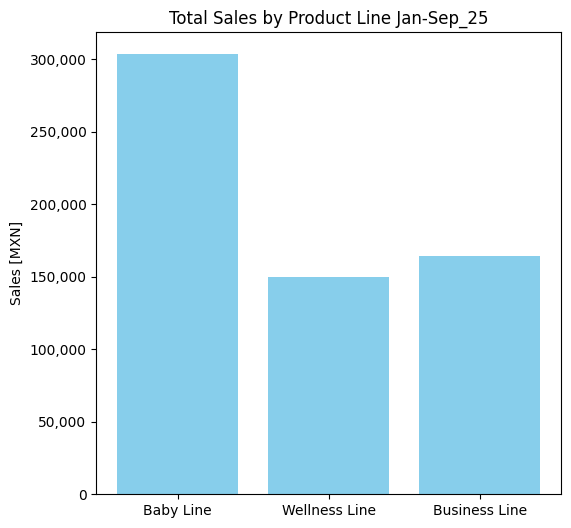

In [55]:

# Let's find the sales by product line.
# First we calculate the total sales by line.
sales_by_line = sales[['baby_sales','wellness_sales','business_sales']].sum()

# Now we transform the Series into a DataFrame.
sales_by_line_df = sales_by_line.reset_index()

# We need to rename the new columns now.
sales_by_line_df.columns = ['product_line', 'total_sales']

# Finally we show the sales by product line in a bar chart.
plt.figure(figsize=(6,6))
plt.bar(sales_by_line_df['product_line'], sales_by_line_df['total_sales'], color='skyblue')
plt.title('Total Sales by Product Line Jan-Sep_25')
plt.ylabel('Sales [MXN]')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.xticks(ticks=[0,1,2], labels=['Baby Line','Wellness Line','Business Line'])
plt.show()


## A/B Test


Finally the Marketing department aims to determine, with statistical evidence, which e-commerce platform generates the highest sales for their baby product line.

In [57]:

# A/B Test for the baby sales in amazon and mercado libre.

# First we gather the sales of the specific product line for each channel.
amazon_baby_sales = sales[sales['channel']=='AZ']['baby_sales']
mercadolibre_baby_sales = sales[sales['channel']=='ML']['baby_sales']

# We see if the variences of both samples are equal or not.
alpha = 0.05
p_value_levene = st.levene(amazon_baby_sales, mercadolibre_baby_sales).pvalue
if p_value_levene < alpha:
    print('The variances of both samples are NOT equal')
else:
    print('There is not enough evidence to say that the variances of both samples are NOT equal')


# Let's define de null hypothesis and the alternative hypothesis.

print('H0 = The sales of the baby line in amazon and mercadolibre ARE the same.')
print('H1 = The sales of the baby line in amazon and mercadolibre ARE NOT the same.')


# We do the T-Student test to determine if the means of both samples are significally separated one from each other, considering 
# that the variances of these are not equal.

result = st.ttest_ind(amazon_baby_sales, mercadolibre_baby_sales, equal_var = False)


# We show the obtained p value from the previous test.

print('The p values is: ', result.pvalue)


# We decide if we reject the nule hypothesis or we don't.

if result.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

The variances of both samples are NOT equal
H0 = The sales of the baby line in amazon and mercadolibre ARE the same.
H1 = The sales of the baby line in amazon and mercadolibre ARE NOT the same.
The p values is:  1.8292007712217375e-22
We reject the null hypothesis
